# Training example

In [1]:
# load all libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Load data

In [2]:
# list data folder
!ls ZH/

cHW-003.txt  cHW+003.txt  plots.pdf  SM.txt  Zbb.txt


In [3]:
# load data-sets
sm = pd.read_csv('ZH/SM.txt')
bsm = pd.read_csv('ZH/cHW+003.txt')
bkg = pd.read_csv('ZH/Zbb.txt')



In [4]:
# clean-up column names
sm.columns = map(lambda x: x.replace(" ","").replace('#',''),sm.columns)
bsm.columns = map(lambda x: x.replace(" ","").replace('#',''),bsm.columns)
bkg.columns = map(lambda x: x.replace(" ","").replace('#',''),bkg.columns)


In [5]:
sm.columns

Index(['wgt', 'pTZ', 'MVH', 'yZ', 'yH', 'etaZ', 'etaH', 'pTb1', 'pTb2', 'pTl1',
       'pTl2', 'etab1', 'etab2', 'etal1', 'etal2', 'Mbb', 'nj_pT20'],
      dtype='object')

## Prepare for training

In [6]:
# define labels: 0: BSM, 1: SM, 2:background
bsm['label'] = np.zeros((bsm.shape[0],1))
sm['label'] = np.ones((sm.shape[0],1))
bkg['label'] = np.ones((bkg.shape[0],1))*2


In [7]:
# input features
features = [ 'pTZ', 'MVH', 'etaZ', 'pTb1', 'pTb2', 'pTl1', 'pTl2', 'etab1',
       'etab2', 'etal1', 'etal2' ]


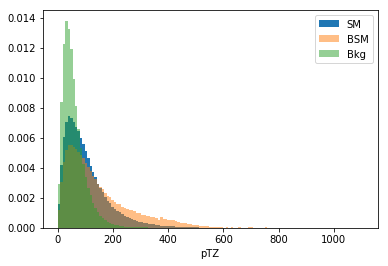

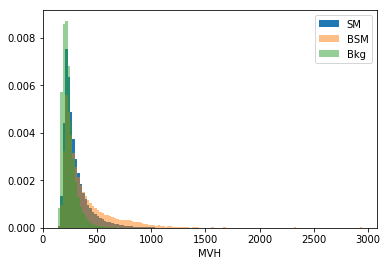

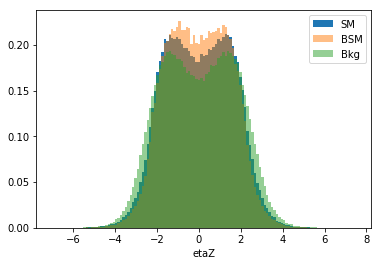

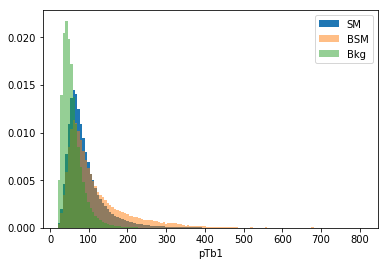

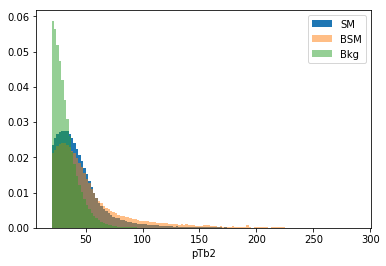

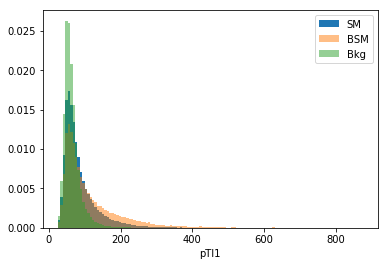

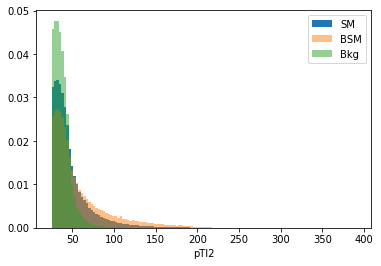

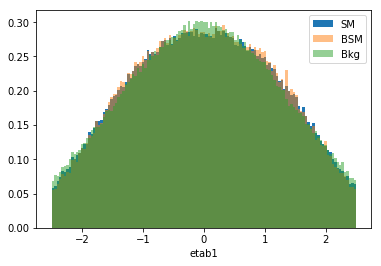

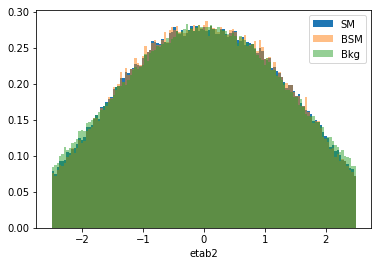

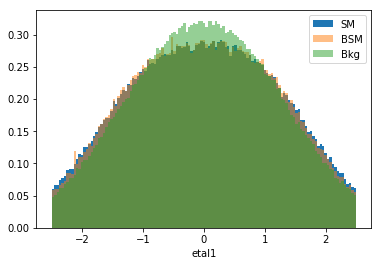

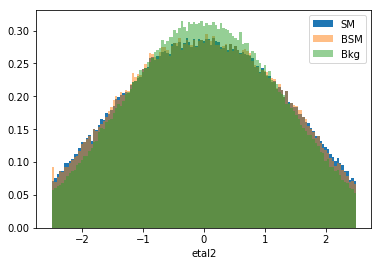

In [8]:
# plot input features
for feature in features:
    _, bins, _ = plt.hist(sm[feature],bins=125,label='SM',weights=sm.wgt,normed=True)
    plt.hist(bsm[feature],bins=bins,label='BSM',weights=bsm.wgt,alpha=0.5,normed=True)
    plt.hist(bkg[feature],bins=bins,label='Bkg',weights=bkg.wgt,alpha=0.5,normed=True)
    plt.xlabel(feature)
    plt.legend()
    plt.show()

In [32]:
# normalize weights
ref = sm.shape[0]
sm['wgt'] /= sm['wgt'].sum() / ref
bsm['wgt'] /= bsm['wgt'].sum() / ref
bkg['wgt'] /= bkg['wgt'].sum() / ref

In [33]:
# Merge data-sets into a single one
df = pd.concat([sm,bsm,bkg])

In [34]:
print('Full dataset has shape ',df.shape)

Full dataset has shape  (1052966, 18)


In [35]:
df.groupby('label')['wgt'].mean()

label
0.0    0.999752
1.0    1.000000
2.0    0.898227
Name: wgt, dtype: float64

In [36]:
# shuffle data-set
seed = 56789
np.random.seed(seed)
random_index = np.array(range(df.shape[0]))

np.random.shuffle(random_index)

df['random_index'] = random_index

df.set_index('random_index',inplace=True)

df.sort_index(inplace=True)

In [37]:
# get featrues and target
X = df[features]
y = df['label']
w = df['wgt']

## Train BDT

In [38]:
from sklearn import ensemble


In [39]:
from sklearn.model_selection import train_test_split


In [40]:
# split into train and test sample
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,random_state=123456)

print(X_train.shape)

(789724, 11)


In [41]:
# possibly limit number of training entries
nentries = 50000
## nentries = -1
X_train = X_train[:nentries]
y_train = y_train[:nentries]
w_train = w_train[:nentries]

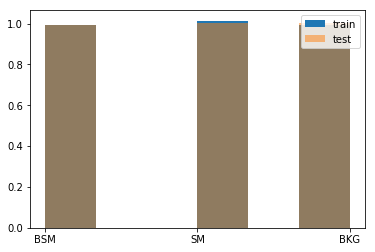

In [43]:
plt.hist(y_train,label='train',normed=True,bins=6,weights=w_train)
plt.hist(y_test,label='test',normed=True,bins=6,alpha=0.5,weights=w_test)
plt.xticks(range(3),('BSM','SM','BKG'))
# plt.yscale('log')
plt.legend()

In [55]:
# instantiate classifier
clf = ensemble.GradientBoostingClassifier(max_depth=10,n_estimators=300,subsample=0.8,
                                        learning_rate=0.05)


In [65]:
# train it
%time clf.fit(X_train,y_train,w_train)

CPU times: user 10min 41s, sys: 47.8 ms, total: 10min 41s
Wall time: 10min 41s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

## Apply BDT

In [66]:
%time y_pred = clf.predict_proba(X_test)

CPU times: user 11.9 s, sys: 16.7 ms, total: 11.9 s
Wall time: 11.9 s


In [67]:
bsm_pred = y_pred[ y_test== 0]
sm_pred = y_pred[ y_test== 1]
bkg_pred = y_pred[ y_test== 2]

bsm_w = w_test[ y_test== 0]
sm_w = w_test[ y_test== 1]
bkg_w = w_test[ y_test== 2]


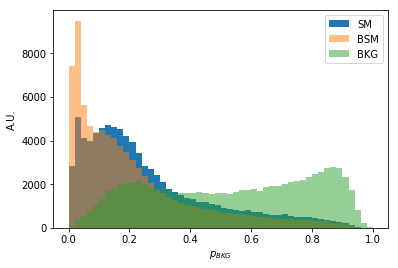

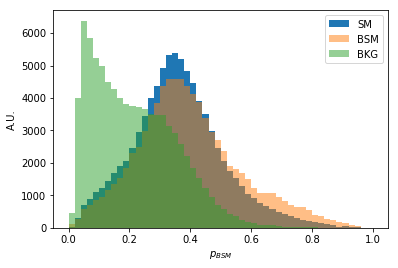

In [74]:
for iprob,label in (2,'$p_{BKG}$'),(0,'$p_{BSM}$'):
    plt.hist(sm_pred[:,iprob],weights=sm_w,range=[0,1],bins=50,label='SM')
    plt.hist(bsm_pred[:,iprob],weights=bsm_w,range=[0,1],bins=50,alpha=0.5,label='BSM');
    plt.hist(bkg_pred[:,iprob],weights=bkg_w,range=[0,1],bins=50,alpha=0.5,label='BKG');
    plt.xlabel('%s' % label)
    plt.ylabel('A.U.')
    plt.legend()
    plt.show()


Text(0,0.5,'A.U.')

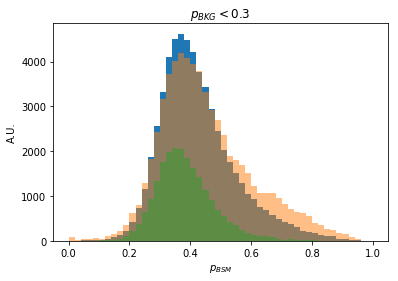

In [77]:
plt.hist(sm_pred[:,0],weights=sm_w*(sm_pred[:,2]<0.3),range=[0,1],bins=50,label='SM')
plt.hist(bsm_pred[:,0],weights=bsm_w*(bsm_pred[:,2]<0.3),range=[0,1],bins=50,alpha=0.5,label='BSM');
plt.hist(bkg_pred[:,0],weights=bkg_w*(bkg_pred[:,2]<0.3),range=[0,1],bins=50,alpha=0.5,label='BKG');
plt.title('$p_{BKG} < 0.3$')
plt.xlabel('$p_{BSM}$')
plt.ylabel('A.U.')

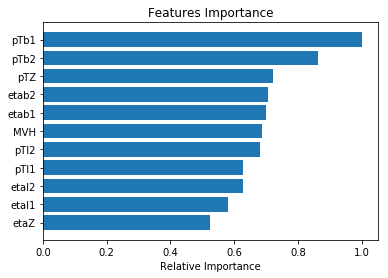

In [70]:
feature_importance = clf.feature_importances_
feature_importance /= feature_importance.max()
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Features Importance')
plt.show()